In [1]:
from importlib import reload
import os

import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
from cupyx.scipy.spatial.distance import cdist
import black
import jupyter_black
jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)
import warnings
warnings.filterwarnings('ignore')

import utils

correction_step = "cc_not_adjusted_PCA" # "harmony" or "chromosome-correction"

DEBUG:jupyter_black:Using config from /dgx1nas1/storage/data/sam/codes/morphmap/08.compare-crispr-similarity/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
if correction_step == "well_mean_correction":
    df_mad = pd.read_parquet('../jump-CRISPR-data/raw_filtered_profiles.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/full_profiles_mean_corrected.parquet')

if correction_step == "cell_count":
    df_mad = pd.read_parquet('../jump-CRISPR-data/full_profiles_mean_corrected.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/profiles_cc_adjusted.parquet')

if correction_step == "mad":
    df_mad = pd.read_parquet('../jump-CRISPR-data/profiles_cc_adjusted.parquet')
    
    path = '../../2023_Arevalo_BatchCorrection/output/no_sphering/0b0bc101834dee90890228fc19197733/sphering/corrected.h5ad'
    df_harm = ad.read_h5ad(path)
    df_harm = utils.obsm_to_df(df_harm, 'X_sphering', None)
    
if correction_step == "harmony":
    df_mad = pd.read_parquet('../jump-CRISPR-data/robustmad_adjusted.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/crispr_harmonized_no_sphering_profiles.parquet')

if correction_step == "chromosome-correction":
    # Read in Harmonized profile
    df_mad = pd.read_parquet('../jump-CRISPR-data/crispr_harmonized_no_sphering_profiles.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/harmonized_CRISPR_corrected.parquet')
    df_harm = df_harm[df_mad.columns]

if correction_step == "PCA-arm-corrected":
    df_mad = pd.read_parquet('../jump-CRISPR-data/harmonized_PCA_CRISPR.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/harmonized_PCA_CRISPR_corrected.parquet')
    df_harm = df_harm[df_mad.columns]

if correction_step == "cc_not_adjusted":
    df_mad = pd.read_parquet('../jump-CRISPR-data/mad_int_featselect_harmony.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/cc_notadjusted_corrected.parquet')

if correction_step == "cc_not_adjusted_PCA":
    df_mad = pd.read_parquet('../jump-CRISPR-data/cc_notadjusted_PCA.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/cc_notadjusted_PCA_corrected.parquet')

In [3]:
if correction_step == "recursion":
    df_mad = pd.read_parquet('../jump-CRISPR-data/recursion_profiles_precorrect.parquet')
    df_harm = pd.read_parquet('../jump-CRISPR-data/recursion_profiles_postcorrect.parquet')

In [4]:
# Read metadata 
df_chrom = pd.read_csv('../01.create-annotations/output/gene_chromosome_map.tsv', sep='\t', dtype=str)
df_an = pd.read_csv('../jump-CRISPR-data/crispr.csv.gz')

In [5]:
%%time
# Sort dataframes based on chromosome location
df_mad = utils.order_dataframe_based_on_chromosome(df_mad, df_an, df_chrom)
print(df_mad.shape)

df_harm = utils.order_dataframe_based_on_chromosome(df_harm, df_an, df_chrom)
print(df_harm.shape)

Removed nan features: []
(7821, 414)
Removed nan features: []
(7821, 414)
CPU times: user 880 ms, sys: 80.5 ms, total: 961 ms
Wall time: 991 ms


In [6]:
%%time
# Compute Cosine Similarity
feat_col = df_mad.filter(regex="^(?!Metadata_)").columns
COS_pre_harmony = (1 - cdist(df_mad[feat_col], df_mad[feat_col], metric="cosine")).astype('float16')

feat_col = df_harm.filter(regex="^(?!Metadata_)").columns
COS_post_harmony = (1 - cdist(df_harm[feat_col], df_harm[feat_col], metric="cosine")).astype('float16')

CPU times: user 3.55 s, sys: 1.09 s, total: 4.63 s
Wall time: 8.6 s


In [7]:
%%time
COS_pre_harmony_norm = utils.quantile_normalize_to_normal(COS_pre_harmony)
COS_post_harmony_norm = utils.quantile_normalize_to_normal(COS_post_harmony)

CPU times: user 37.8 s, sys: 740 ms, total: 38.6 s
Wall time: 38.7 s


In [8]:
# Combine two COS matrices into one
reload(utils)
combined_matrix = utils.combine_two_matrices(COS_pre_harmony_norm, COS_post_harmony_norm)

In [9]:
# Compute position of chromosome and arm in heatmap for plotting
chrom_idx = utils.compute_group_border(df_mad, 'Metadata_Chromosome')
arm_idx = utils.compute_group_border(df_mad, 'Metadata_arm')
arm_idx = list(set(arm_idx) - set(chrom_idx))

In [10]:
combined_matrix = cp.asnumpy(combined_matrix)

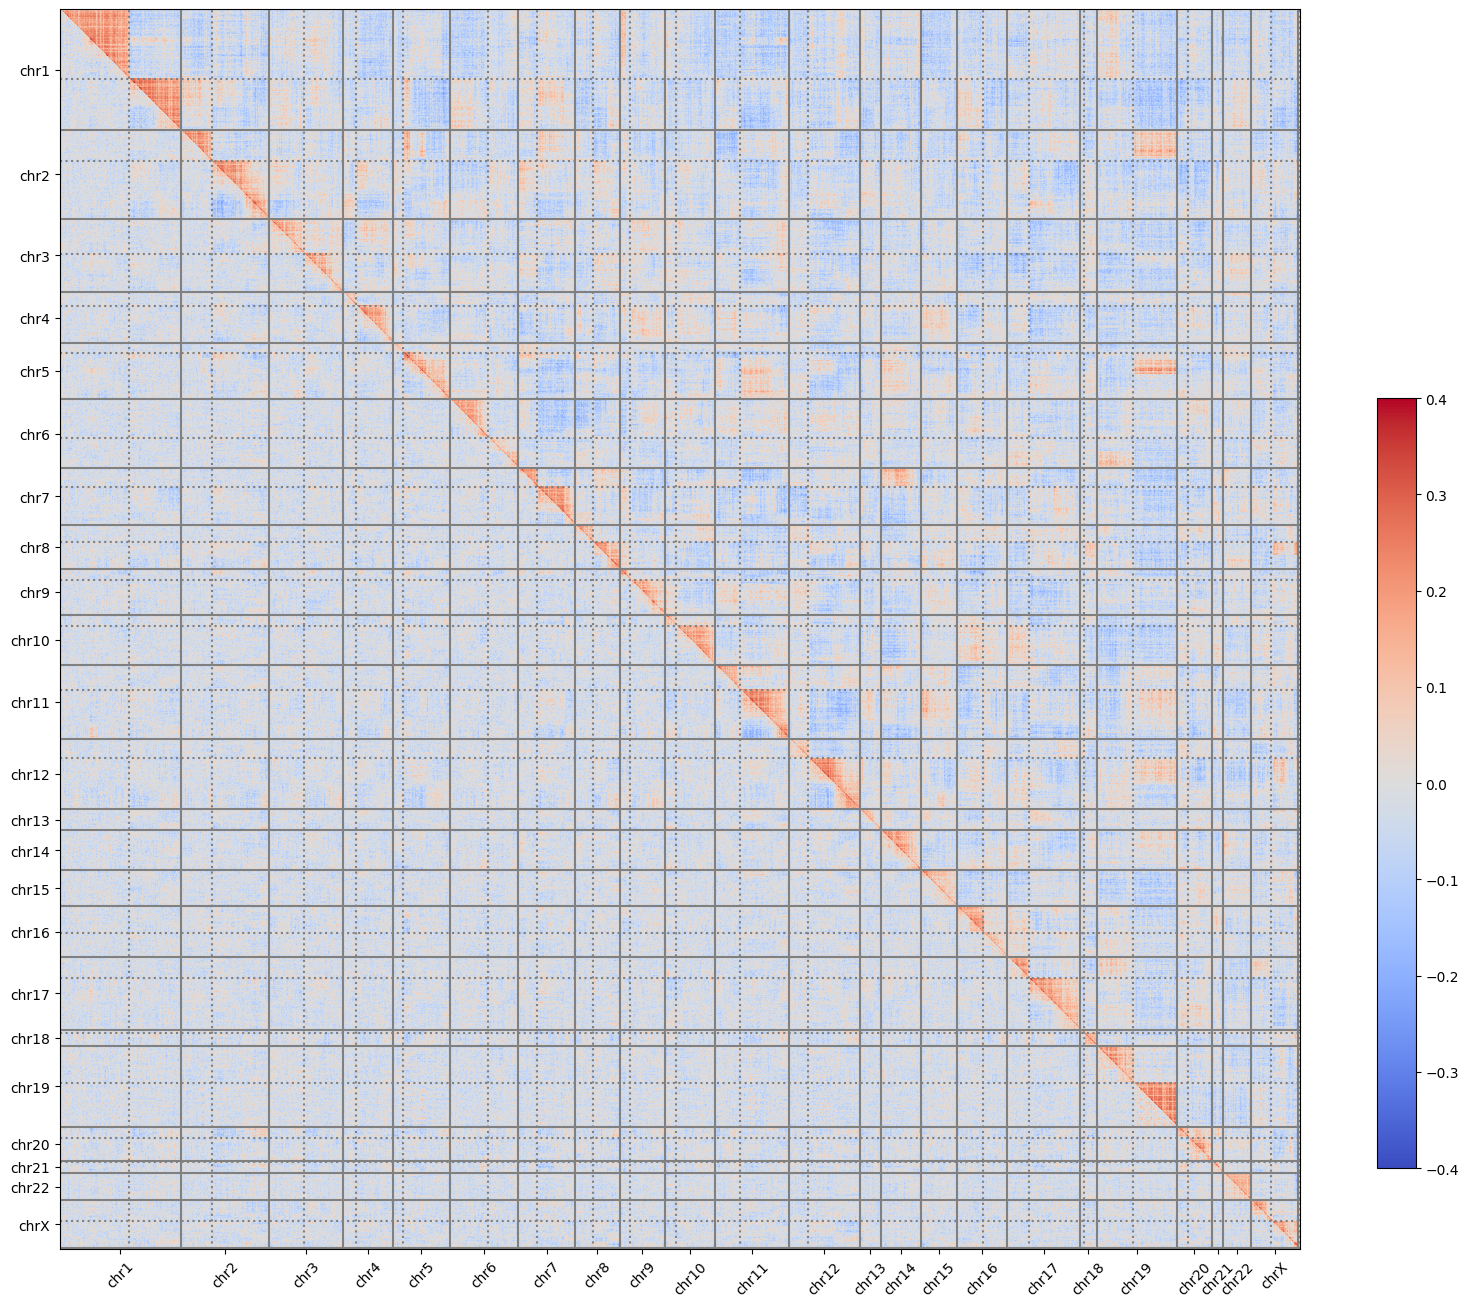

CPU times: user 9.48 s, sys: 724 ms, total: 10.2 s
Wall time: 10.6 s


In [11]:
%%time
fig, ax = plt.subplots(figsize=[20, 20])
colmap = sns.color_palette("coolwarm", as_cmap=True)

im = plt.imshow(combined_matrix, 
                 cmap=colmap,
                vmin=-0.4,
                vmax=0.4,
                 aspect='equal')

fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.3), shrink=0.5)

ax.hlines(chrom_idx, color='gray', *ax.get_xlim())
ax.hlines(arm_idx, color='gray', linestyles='dotted', *ax.get_xlim())
ax.vlines(chrom_idx, color='gray', *ax.get_ylim())
ax.vlines(arm_idx, color='gray', linestyles='dotted', *ax.get_ylim())

tick_pos = [(chrom_idx[i]+chrom_idx[i+1])//2 for i in range(0, len(chrom_idx)-1)]
tick_labels = ['chr' + i for i in df_mad['Metadata_Chromosome'].unique()[:-1]]
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set(xlabel='', ylabel='')
ax.grid(False)
plt.show()

In [12]:
if not os.path.isdir('output'):
    os.mkdir('output')
fig.savefig(f'output/pre_post_{correction_step}_heatmap_normalized_2std.png',bbox_inches="tight")